In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from keras.preprocessing.image import load_img, img_to_array

2024-11-22 14:29:31.099731: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732260571.293904   19950 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732260571.336966   19950 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 14:29:31.569609: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Path ke direktori dataset
train_dir = '../datasets/train_looking_right_set'
validation_dir = '../datasets/test_looking_right_set'

In [3]:
# Data augmentation dan preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    brightness_range=[0.8, 1.2],
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 1202 images belonging to 2 classes.
Found 302 images belonging to 2 classes.


In [4]:
# Load MobileNetV3 model
base_model = MobileNetV3Large(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

/home/brimbi21/anaconda3/envs/lDetection/lib/python3.10/site-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(
I0000 00:00:1732260589.607200   19950 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [5]:
checkpoint_path = "../model_download/looking_right/pertama/model_looking_right.keras"
checkpoint = tf.keras.callbacks.ModelCheckpoint(
                filepath=checkpoint_path,
                monitor="val_accuracy",
                verbose=1,
                save_best_only=True,
                save_weights_only=False,
                mode="max",
                save_freq="epoch",
            )
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [6]:
# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10,
    callbacks=[checkpoint, early_stopping]
)

/home/brimbi21/anaconda3/envs/lDetection/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


2024-11-22 14:30:50.726688: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.
I0000 00:00:1732260651.082666   21056 service.cc:148] XLA service 0x7face8019e80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732260651.088503   21056 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2024-11-22 14:30:58.627871: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-22 14:31:01.406837: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.
I0000 00:00:1732260665.052691   21056 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-22 14:31:09.514369: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Regi

 3/37 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - Precision: 0.7070 - Recall: 0.9016 - accuracy: 0.6944 - loss: 0.6281  

2024-11-22 14:31:29.723573: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.


 4/37 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - Precision: 0.7192 - Recall: 0.9051 - accuracy: 0.7181 - loss: 0.6000

2024-11-22 14:31:31.610272: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.


 5/37 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - Precision: 0.7301 - Recall: 0.9023 - accuracy: 0.7320 - loss: 0.5815

2024-11-22 14:31:33.234212: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.


21/37 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - Precision: 0.7935 - Recall: 0.8970 - accuracy: 0.8084 - loss: 0.4511

2024-11-22 14:32:07.804120: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_9635', 8 bytes spill stores, 8 bytes spill loads

2024-11-22 14:32:08.414687: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3470', 8 bytes spill stores, 8 bytes spill loads

2024-11-22 14:32:08.575201: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3470', 12 bytes spill stores, 12 bytes spill loads

2024-11-22 14:32:08.605757: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_9635', 8 bytes spill stores, 8 bytes spill loads

2024-11-22 14:32:09.018921: I external/local_xla/xla/stream_execut

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - Precision: 0.8202 - Recall: 0.8999 - accuracy: 0.8361 - loss: 0.3954

/home/brimbi21/anaconda3/envs/lDetection/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.62153, saving model to ../model_download/looking_right/pertama/model_looking_right.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - Precision: 0.8215 - Recall: 0.9001 - accuracy: 0.8374 - loss: 0.3928 - val_Precision: 0.9737 - val_Recall: 0.2552 - val_accuracy: 0.6215 - val_loss: 1.9017
Epoch 2/10
 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - Precision: 1.0000 - Recall: 0.7857 - accuracy: 0.9062 - loss: 0.3800

2024-11-22 14:33:01.972631: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-22 14:33:01.973197: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/home/brimbi21/anaconda3/envs/lDetection/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-11-22 14:33:05.530085: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1557', 268 bytes spill stores, 300 bytes spill loads




Epoch 2: val_accuracy improved from 0.62153 to 0.71429, saving model to ../model_download/looking_right/pertama/model_looking_right.keras


2024-11-22 14:33:14.691453: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-11-22 14:33:14.691547: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12266091921490736415
2024-11-22 14:33:14.691570: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15281155867010061044


37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 383ms/step - Precision: 1.0000 - Recall: 0.7857 - accuracy: 0.9062 - loss: 0.3800 - val_Precision: 1.0000 - val_Recall: 0.3333 - val_accuracy: 0.7143 - val_loss: 1.7603
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - Precision: 0.9128 - Recall: 0.9440 - accuracy: 0.9240 - loss: 0.1735
Epoch 3: val_accuracy did not improve from 0.71429
37/37 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - Precision: 0.9128 - Recall: 0.9441 - accuracy: 0.9241 - loss: 0.1734 - val_Precision: 0.9385 - val_Recall: 0.4266 - val_accuracy: 0.7014 - val_loss: 1.1821
Epoch 4/10
 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - Precision: 0.9524 - Recall: 1.0000 - accuracy: 0.9688 - loss: 0.0413
Epoch 4: val_accuracy improved from 0.71429 to 0.78571, saving model to ../model_download/looking_right/pertama/model_looking_right.keras


2024-11-22 14:34:04.753134: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - Precision: 0.9524 - Recall: 1.0000 - accuracy: 0.9688 - loss: 0.0413 - val_Precision: 1.0000 - val_Recall: 0.6250 - val_accuracy: 0.7857 - val_loss: 1.3776
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - Precision: 0.9552 - Recall: 0.9597 - accuracy: 0.9587 - loss: 0.1016
Epoch 5: val_accuracy did not improve from 0.78571
37/37 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - Precision: 0.9553 - Recall: 0.9599 - accuracy: 0.9588 - loss: 0.1014 - val_Precision: 0.8190 - val_Recall: 0.5972 - val_accuracy: 0.7326 - val_loss: 0.7786
Epoch 6/10
 1/37 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - Precision: 0.9286 - Recall: 1.0000 - accuracy: 0.9688 - loss: 0.1056
Epoch 6: val_accuracy did not improve from 0.78571
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.9286 - Recall: 1.0000 - accuracy: 0.9688 - loss: 0.1056 - val_Precision: 0.8000 - val_Recall: 0.5714 - val_accuracy: 0.7143 - val_loss: 0.5835
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - Precision: 0.

2024-11-22 14:35:51.408220: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-11-22 14:35:51.408307: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12266091921490736415
2024-11-22 14:35:51.408324: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15281155867010061044


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - Precision: 0.9687 - Recall: 0.9830 - accuracy: 0.9774 - loss: 0.0600
Epoch 9: val_accuracy did not improve from 0.78571
37/37 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - Precision: 0.9690 - Recall: 0.9830 - accuracy: 0.9775 - loss: 0.0598 - val_Precision: 0.9306 - val_Recall: 0.4653 - val_accuracy: 0.7153 - val_loss: 1.3391


In [7]:
# Unfreeze beberapa layers dari base model untuk fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Re-compile model dengan learning rate lebih rendah
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/10


E0000 00:00:1732261023.264727   21051 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1732261023.563314   21051 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - Precision: 0.9538 - Recall: 0.9376 - accuracy: 0.9449 - loss: 0.1372
Epoch 1: val_accuracy did not improve from 0.78571
37/37 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - Precision: 0.9539 - Recall: 0.9378 - accuracy: 0.9451 - loss: 0.1368 - val_Precision: 0.6649 - val_Recall: 0.8741 - val_accuracy: 0.7188 - val_loss: 0.6723
Epoch 2/10
 1/37 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - Precision: 0.9412 - Recall: 1.0000 - accuracy: 0.9688 - loss: 0.0609
Epoch 2: val_accuracy did not improve from 0.78571


2024-11-22 14:38:16.484583: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12266091921490736415


37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - Precision: 0.9412 - Recall: 1.0000 - accuracy: 0.9688 - loss: 0.0609 - val_Precision: 0.7273 - val_Recall: 1.0000 - val_accuracy: 0.7857 - val_loss: 0.3096
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - Precision: 0.9335 - Recall: 0.9816 - accuracy: 0.9580 - loss: 0.0986
Epoch 3: val_accuracy did not improve from 0.78571
37/37 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - Precision: 0.9341 - Recall: 0.9814 - accuracy: 0.9582 - loss: 0.0983 - val_Precision: 0.7470 - val_Recall: 0.8552 - val_accuracy: 0.7812 - val_loss: 0.5511
Epoch 4/10
 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - Precision: 0.9412 - Recall: 1.0000 - accuracy: 0.9688 - loss: 0.0836
Epoch 4: val_accuracy improved from 0.78571 to 0.92857, saving model to ../model_download/looking_right/pertama/model_looking_right.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - Precision: 0.9412 - Recall: 1.0000 - accuracy: 0.9688 - loss: 0.0836 - val_Precision: 0.8571 - val_Recall: 1.0000 - val_accuracy: 0

In [8]:
# Evaluasi Model
loss, accuracy, precision, recall = model.evaluate(validation_generator)
print(f"Loss: {loss}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 669ms/step - Precision: 0.7728 - Recall: 0.8562 - accuracy: 0.7874 - loss: 0.5425
Loss: 0.5272790193557739, Accuracy: 0.7880794405937195, Precision: 0.7514451146125793, Recall: 0.860927164554596


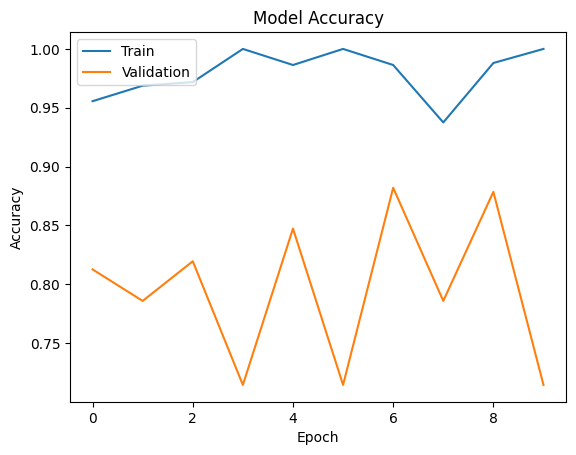

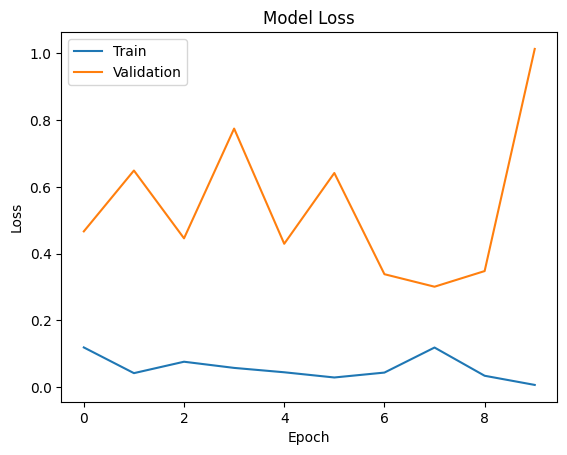

In [9]:
# Plot accuracy dan val_accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss dan val_loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Prediction: Right
Confidence score: 0.9972


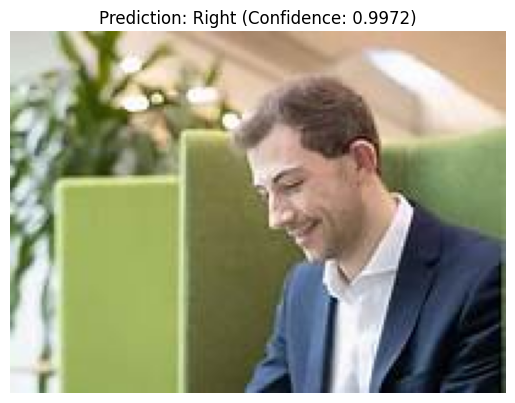

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction: Right
Confidence score: 0.8341


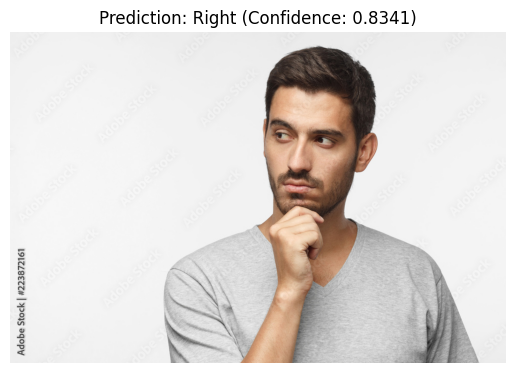

In [10]:
# Load the saved model
model = tf.keras.models.load_model('../model_download/looking_left/pertama/model_looking_left.keras')

# Function to preprocess an image for prediction
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    # img_array /= 255.  # Normalize the image if your model expects normalized input
    return img_array

# Function to predict and display results
def predict_image(image_path):
    preprocessed_image = preprocess_image(image_path)
    prediction = model.predict(preprocessed_image)

    if prediction[0][0] > 0.5:
        label = "Right"
    else:
        label = "Front Facing"

    confidence = prediction[0][0] if label == "Right" else 1 - prediction[0][0]

    print(f"Prediction: {label}")
    print(f"Confidence score: {confidence:.4f}")
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.title(f"Prediction: {label} (Confidence: {confidence:.4f})")
    plt.axis('off')
    plt.show()

# Example usage:
test_image_path1 = "../datasets/test/test/right.jpeg"
test_image_path2 = "../datasets/test/test/1000_F_223872161_YZ98dGUBv8Oh7ce3WgF4JRbT9u07Nv4m.jpg"

predict_image(test_image_path1)
predict_image(test_image_path2)

In [11]:
import time

# Fungsi untuk memuat dan memproses gambar
def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v3.preprocess_input(img_array)
    return img_array

# Mengonversi model ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Menyimpan model TFLite ke file
tflite_model_path = '../model_download/looking_right/pertama/model_looking_right.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

# Mengukur latensi model TFLite
def measure_tflite_latency(image_path, tflite_model_path, num_runs=100):
    # Memuat model TFLite
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()
    
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Mendapatkan ukuran input yang diharapkan
    input_shape = input_details[0]['shape'][1:3]
    
    preprocessed_image = preprocess_image(image_path, target_size=input_shape)
    
    # Warm-up
    for _ in range(10):
        interpreter.set_tensor(input_details[0]['index'], preprocessed_image)
        interpreter.invoke()
    
    # Mengukur latensi
    start_time = time.time()
    for _ in range(num_runs):
        interpreter.set_tensor(input_details[0]['index'], preprocessed_image)
        interpreter.invoke()
    end_time = time.time()
    
    avg_latency = (end_time - start_time) / num_runs
    print(f"Average TFLite latency over {num_runs} runs: {avg_latency:.6f} seconds")

# Contoh penggunaan
test_image_path = "../datasets/test/test/right.jpeg"
measure_tflite_latency(test_image_path, tflite_model_path)

INFO:tensorflow:Assets written to: /tmp/tmpf8a4q24z/assets


INFO:tensorflow:Assets written to: /tmp/tmpf8a4q24z/assets


Saved artifact at '/tmp/tmpf8a4q24z'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140381156267408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140381156399712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140381156406400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140381156353728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140381156398480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140381156356368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140381156310736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140381156307216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140381156307568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140381156295072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14038115612

W0000 00:00:1732261389.373738   19950 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732261389.373799   19950 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-11-22 14:43:09.375067: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpf8a4q24z
2024-11-22 14:43:09.388024: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-11-22 14:43:09.388075: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpf8a4q24z
I0000 00:00:1732261389.506603   19950 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2024-11-22 14:43:09.528432: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-11-22 14:43:10.889978: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpf8a4q24z
2024-11-22 14:43:11.213559: I tensorflow/cc/saved_model/loader.cc:466] SavedModel 

Average TFLite latency over 100 runs: 0.001223 seconds


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [12]:
# Memuat model Keras
model = tf.keras.models.load_model('../model_download/looking_right/pertama/model_looking_right.keras')

# Mengonversi model ke TFLite dengan kuantisasi rentang dinamis
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_quant = converter.convert()

# Menyimpan model TFLite yang telah dikuantisasi ke file
tflite_model_quant_path = '../model_download/looking_right/model_looking_right_quant.tflite'
with open(tflite_model_quant_path, 'wb') as f:
    f.write(tflite_model_quant)

print("Model TFLite dengan kuantisasi rentang dinamis telah disimpan.")

INFO:tensorflow:Assets written to: /tmp/tmp9_261oqv/assets


INFO:tensorflow:Assets written to: /tmp/tmp9_261oqv/assets


Saved artifact at '/tmp/tmp9_261oqv'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140380357057472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140380357068400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140380357070512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140380357063632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140380357065920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140380357079312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140380357077376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140380357080368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140380357077024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140380357077728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1403803570805

W0000 00:00:1732261406.927569   19950 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732261406.927634   19950 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-11-22 14:43:26.927862: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp9_261oqv
2024-11-22 14:43:26.940254: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-11-22 14:43:26.940304: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp9_261oqv
2024-11-22 14:43:27.080602: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-11-22 14:43:27.889106: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp9_261oqv
2024-11-22 14:43:28.162616: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 1234759 microseconds.


Model TFLite dengan kuantisasi rentang dinamis telah disimpan.
